### EXCEL MANIPULATION

In [8]:
import pandas as pd

# Load the CSV data into a DataFrame
df = pd.read_csv('Datasets/mosei/mosei_test_updated.csv')

# Define the labels you want to keep
labels_to_keep = ['happy', 'sad', 'anger', 'fear']

# Filter the DataFrame to keep only the rows where the 'label' column matches one of the specified labels
filtered_df = df[df['label'].isin(labels_to_keep)]

# Save the filtered DataFrame to a new CSV file
filtered_df.to_csv('mosei_test_filtered.csv', index=False)

# Display the filtered DataFrame
print(filtered_df)

         happy       sad     anger  surprise  disgust      fear  \
0     1.333333  0.000000  0.000000       0.0      0.0  0.000000   
1     0.333333  0.666667  0.000000       0.0      0.0  0.000000   
2     0.000000  0.666667  0.000000       0.0      0.0  0.000000   
12    0.000000  0.333333  0.333333       0.0      0.0  0.666667   
14    0.000000  0.000000  0.666667       0.0      0.0  0.000000   
...        ...       ...       ...       ...      ...       ...   
1973  0.666667  0.000000  0.000000       0.0      0.0  0.000000   
1974  0.666667  0.000000  0.000000       0.0      0.0  0.000000   
1977  0.666667  0.000000  0.000000       0.0      0.0  0.333333   
1980  2.333333  0.000000  0.000000       0.0      0.0  0.000000   
1981  0.666667  0.000000  0.000000       0.0      0.0  0.000000   

                                                    ASR  label  \
0      especially if i'd say hey can what i really l...  happy   
1                    i've seen this in us or in the u s    sad 

## AUDIO GENERATION

In [16]:
from audioGan import AudioGAN
from ganSetup import GANConfig
import numpy as np
import soundfile as sf
import IPython.display as ipd
import matplotlib.pyplot as plt
import IPython
import librosa
import numpy as np

config = GANConfig()
myGan = AudioGAN(label = config.LABEL, load= True)


fname


/home/guneshwar/projects/mine/Audio_Generation_emotion_0/.venv/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:396: UserWarning: Skipping variable loading for optimizer 'adam', because it has 46 variables whereas the saved optimizer has 2 variables. 
  trackable.load_own_variables(weights_store.get(inner_path))


Generator model loaded from ./models/generator.keras


/home/guneshwar/projects/mine/Audio_Generation_emotion_0/.venv/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:396: UserWarning: Skipping variable loading for optimizer 'adam', because it has 38 variables whereas the saved optimizer has 2 variables. 
  trackable.load_own_variables(weights_store.get(inner_path))


Discriminator model loaded from ./models/discriminator.keras
Autoencoder model loaded from ./models/autoencoder.keras
Loaded


In [36]:
import librosa

def process_audio_file(file_path, input_length):
    try:
        data, _ = librosa.load(file_path, sr=config.SAMPLE_RATE, res_type='kaiser_fast')
        if len(data) > input_length:
            offset = np.random.randint(len(data) - input_length)
            data = data[offset:offset + input_length]
        else:
            data = np.pad(data, (0, input_length - len(data)), 'constant')
        return data
    except Exception as e:
        print(f"Error loading {file_path}: {e}")
        return np.zeros(input_length)

In [37]:
file_path = 'Datasets/mosei/audio_test/_1nvuNk7EFY_42.7354_46.6964.wav'

audio_data = process_audio_file(file_path, 4)


In [21]:
myGan.testData[1]

array([0.06346942, 0.06543159, 0.05594039, ..., 0.02659096, 0.01249384,
       0.01267113])

### SAVING VGG

In [31]:
import tensorflow as tf
import os
##VGG MODEL
model= tf.keras.applications.VGG19( include_top=True, weights="imagenet", input_tensor=None, input_shape=None, pooling=None, classes=1000, classifier_activation="softmax", )
vgg_path = os.path.join('./models/model_vgg19.keras')
model.save(vgg_path)

### AUTOENCODER PLOT

In [40]:
file_path = 'Datasets/mosei/audio_test/_1nvuNk7EFY_42.7354_46.6964.wav'
audio_data = process_audio_file(file_path, input_length=4)

print("Original:")
ipd.display(ipd.Audio(data=audio_data, rate=config.SAMPLE_RATE))
# sf.write(config.AUTO_ENCODER_PATH + "AE_Original_test_" + config.LABEL + ".wav", audio_data, config.SAMPLE_RATE)

result = myGan.autoencoder.predict(audio_data.reshape((1, config.AUDIO_SHAPE))).flatten()
sf.write("AE_output.wav", result, 16000)

print("Result:")
ipd.display(ipd.Audio(data=result, rate=config.SAMPLE_RATE))
# sf.write(config.AUTO_ENCODER_PATH + "AE_Result_test_" + config.LABEL + ".wav", result, config.SAMPLE_RATE)

fig = plt.figure(figsize=(15, 4))
Original = fig.add_subplot(1, 2, 1)
Result = fig.add_subplot(1, 2, 2)
Original.set_title('Original')
Result.set_title('Result')
Original.plot(audio_data, '.', color='blue')
Result.plot(result, '.', color='green')
plt.subplots_adjust(wspace=0.2, hspace=0.3)
plt.show()
fig.savefig(config.PICTURE_PATH + "AE_Compare_test_" + config.LABEL + ".png", bbox_inches="tight")

Original:


AttributeError: 'dict' object has no attribute 'AUDIO_SHAPE'

Original:


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 800ms/step
Result:


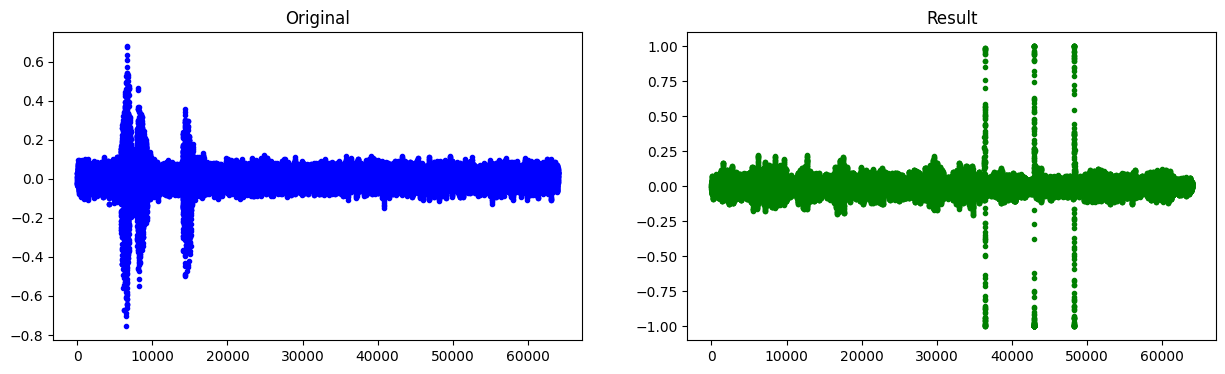

In [23]:
INDEX = 10
sample = myGan.testData[INDEX]

print("Original:")
IPython.display.display(ipd.Audio(data=sample, rate=config.SAMPLE_RATE))
sf.write(config.AUTO_ENCODER_PATH + "AE_Original_test_" + config.LABEL + ".wav", sample, config.SAMPLE_RATE)

result = myGan.autoencoder.predict(sample.reshape((1, config.AUDIO_SHAPE))).flatten()

sf.write("AE_output.wav", result, 16000)


print("Result:")
IPython.display.display(ipd.Audio(data=result, rate=config.SAMPLE_RATE))
sf.write(config.AUTO_ENCODER_PATH + "AE_Result_test_" + config.LABEL + ".wav", result, config.SAMPLE_RATE)

fig = plt.figure(figsize=(15, 4))
Original = fig.add_subplot(1, 2, 1)
Result = fig.add_subplot(1, 2, 2)

Original.set_title('Original')
Result.set_title('Result')

Original.plot(sample, '.', color='blue')
Result.plot(result, '.', color='green')

plt.subplots_adjust(wspace=0.2, hspace=0.3)
plt.show()

fig.savefig(config.PICTURE_PATH + "AE_Compare_test_" + config.LABEL + ".png", bbox_inches="tight")


### GENERATOR PLOT

10
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step
Original Audio:


Generated Audio from Real Audio's Latent Representation:


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 401ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
Original Audio:


Generated Audio from Real Audio's Latent Representation:


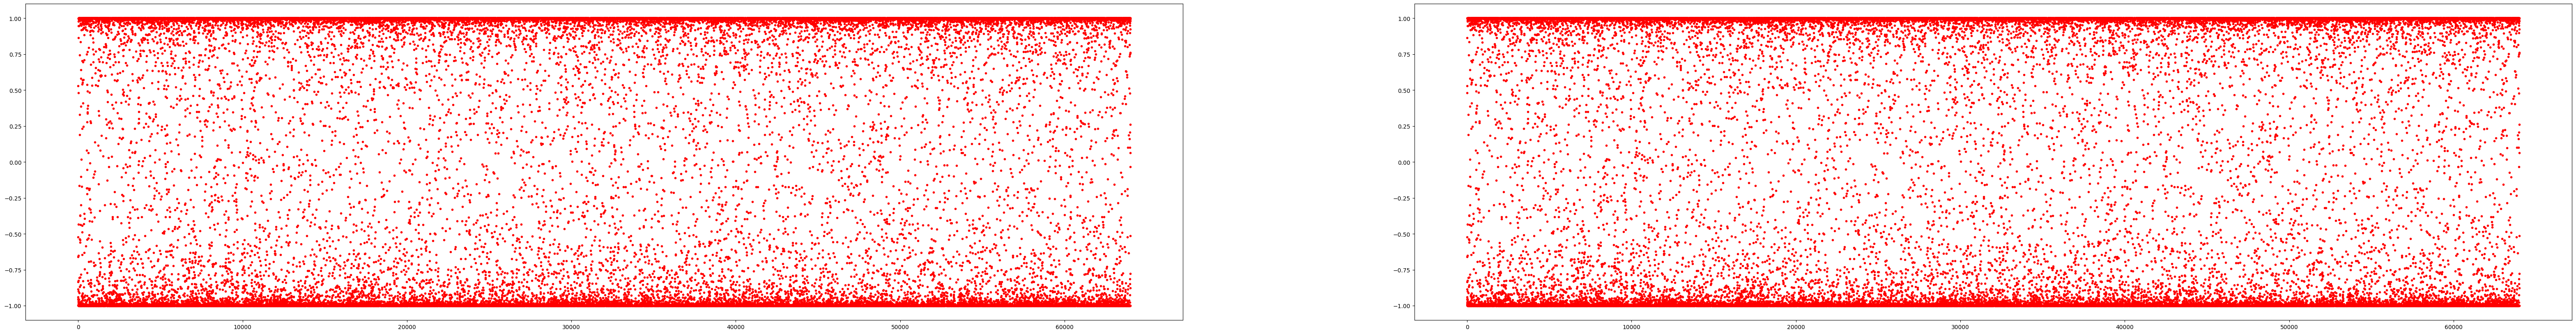

In [24]:
import os
from keras.models import load_model

print(INDEX)
lin, col = 1, 2
fig = plt.figure(figsize=(lin, col))
subPlotS = []
for i in range(lin):
    for j in range(col):
        subPlotS.append(fig.add_subplot(lin , col, (i*col)+j+1))
        
encoder_path = os.path.join(myGan.model_path, 'encoder.keras')
encoder = load_model(encoder_path)
for i in range(lin):
    for j in range(col):
        INDEX = lin
        real_audio = myGan.testData[INDEX]
        gen_noise = np.random.normal(0, 1, (1,config.NOISE_DIM))
        latent_vector = encoder.predict(real_audio.reshape(1, -1))
        generated_audio = myGan.gen.predict(latent_vector).flatten()
        
        # Display the original and reconstructed audio for comparison
        print("Original Audio:")
        ipd.display(ipd.Audio(data=real_audio, rate=myGan.config.SAMPLE_RATE))

        print("Generated Audio from Real Audio's Latent Representation:")
        ipd.display(ipd.Audio(data=generated_audio, rate=myGan.config.SAMPLE_RATE))
        # IPython.display.display(ipd.Audio(data=gen_noise, rate=16000))
        # gen_test = myGan.gen.predict(gen_noise).flatten()
        # IPython.display.display(ipd.Audio(data=gen_test, rate=16000))
        subPlotS[(i*col)+j].plot(generated_audio, '.', color='red')



plt.gcf().set_size_inches(80, 10)
plt.subplots_adjust(wspace=0.2,hspace=0.3)
plt.show()

fig.savefig(config.PICTURE_PATH + "Generated_"+ config.LABEL + ".png", bbox_inches='tight')

In [32]:
from keras.models import load_model
import numpy as np
import IPython.display as ipd
import matplotlib.pyplot as plt
import soundfile as sf  # Assuming you have the soundfile library installed
import os

# Load models
encoder_path = os.path.join(myGan.model_path, 'encoder.keras')
encoder = load_model(encoder_path)
generator_path = os.path.join(myGan.model_path, 'generator.keras')
generator = load_model(generator_path)
config = {'SAMPLE_RATE': 16000}  # Example sample rate

# Function to predict using encoder and generator
def generate_audio_from_real(real_audio):
    # Assuming real_audio is preprocessed and shaped correctly [(1, audio_length)]
    latent_vector = encoder.predict(real_audio.reshape(1, -1))
    generated_audio = generator.predict(latent_vector).flatten()

    # Display and return the audio
    print("Original Audio:")
    ipd.display(ipd.Audio(data=real_audio.flatten(), rate=config['SAMPLE_RATE']))
    print("Generated Audio:")
    ipd.display(ipd.Audio(data=generated_audio, rate=config['SAMPLE_RATE']))

    # Plot the original and generated audio waveforms
    plt.figure(figsize=(12, 6))
    plt.subplot(2, 1, 1)
    plt.title("Original Audio Waveform")
    plt.plot(real_audio)
    plt.subplot(2, 1, 2)
    plt.title("Generated Audio Waveform")
    plt.plot(generated_audio)
    plt.tight_layout()
    plt.show()

    return generated_audio

# Example usage
INDEX = 10
real_audio = myGan.testData[INDEX]  # Replace this with an actual audio sample
generated_audio = generate_audio_from_real(real_audio)

/home/guneshwar/projects/mine/Audio_Generation_emotion_0/.venv/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:396: UserWarning: Skipping variable loading for optimizer 'adam', because it has 46 variables whereas the saved optimizer has 2 variables. 
  trackable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step


ValueError: Input 0 of layer "vgg19" is incompatible with the layer: expected shape=(None, 224, 224, 3), found shape=(1, 64000)